In [ ]:
import numpy as np
import cv2

from google.colab import drive

import torch
from torch import nn

from scipy.io import wavfile

import os
import shutil
import tarfile

import librosa
import random

import time

import IPython.display as ipd

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# тут, собственно, путь до датасета у тебя на гугл диске
path_to_packed_dataset = '/content/drive/My Drive/datasets/crema-d_audio.tar'

# путь до датасета непосредственно в колабе
target_path = '/content/Dataset'

# создаем папку в колабе
if not os.path.isdir(target_path):
    os.mkdir(target_path)

# копируем в колаб
path_to_packed_dataset = shutil.copy2(path_to_packed_dataset, target_path)

print('The archive was copied')

# Распаковываем файлы
with tarfile.open(path_to_packed_dataset) as tar:
    tar.extractall(target_path)

print('The archive was unpacked to ' + target_path)

The archive was copied
The archive was unpacked to /content/Dataset


In [ ]:
path_to_wavs = '/content/Dataset/AudioWAV'

wavs_list = [os.path.join(path_to_wavs, item) for item in os.listdir(path_to_wavs) if item.endswith('.wav')]

In [ ]:
sr, wav = wavfile.read(wavs_list[1])
wav = wav/32768

wav = librosa.effects.time_stretch(wav, 1.1)
print(wav.shape)
wav = librosa.effects.pitch_shift(wav, sr=sr, n_steps=-1.1)

wav = wav + np.random.randn(len(wav)) * 0.005

ipd.Audio(wav, rate=sr)

(35328,)


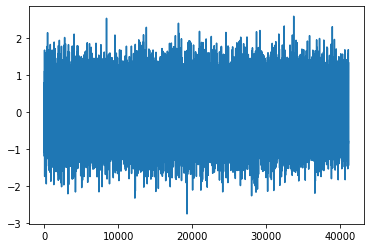

In [ ]:
plt.plot(wav)

In [ ]:
steps = 100
t0 = time.time()
for i in range(100):
    sr, wav = wavfile.read(wavs_list[0])
    wav = wav/32768
    #print(wav.shape)
    wav = librosa.effects.time_stretch(wav, 2)
    #print(wav.shape)
    wav = librosa.effects.pitch_shift(wav, sr=sr, n_steps=-5)

t = time.time() - t0

print(t/steps)
 

0.04341622591018677


In [ ]:
random.randint(0, 1)

1

In [ ]:
def get_paths_to_wavs(path_to_dataset):
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.wav')]

    return file_paths_list

def get_paths_to_npys(path_to_dataset):
    # get a list with all absolute paths to each file
    file_paths_list = []

    for root, dirs, files in os.walk(path_to_dataset):
        if len(files) != 0:
            file_paths_list += [os.path.join(root, f) for f in files if f.endswith('.npy')]
            #file_paths_list += [os.path.join(root, f) for f in files if os.path.isdir(os.path.join(root, f))]

    return file_paths_list

class numpy_ravdess_dataset(torch.utils.data.Dataset):
    '''
    Due to librosa reads wav-files very slow it is more preferable to read the
    numpy representations of the original wavs
    '''

    emotions_dict = {
        0: 'neutral',
        1: 'calm',
        2: 'happy',
        3: 'sad',
        4: 'angry',
        5: 'fearful',
        6: 'disgust',
        7: 'surprised'
        }

    def __init__(self, paths_to_wavs_list, spectrogram_shape, mode):
        super(numpy_ravdess_dataset, self).__init__()

        self.paths_to_wavs_list = paths_to_wavs_list

        self.mfcc_rows = spectrogram_shape[0]
        self.mfcc_cols = spectrogram_shape[1]
        self.mode = mode

    def __len__(self):
        return len(self.paths_to_wavs_list)
    '''
    def read_audio(self, path_to_wav):
        return np.load(path_to_wav, allow_pickle=True)
    '''
    def read_audio(self, path_to_wav):
        sr, wav = wavfile.read(path_to_wav)
        wav = (wav / 32768).astype(np.float32)
        return wav, sr

    def get_class_label(self, path_to_file):
        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        return class_label
        

    def __getitem__(self, idx):
        path_to_wav = self.paths_to_wavs_list[idx]
        # debug
        #print(path_to_wav)

        # read the wav file
        wav, sr = self.read_audio(path_to_wav)
               
        

        # augmentation
        
        if self.mode == 'TRAIN':
            # add noise
            if np.random.randint(0, 2) == 1:
                sigma = np.random.uniform(0.0009, 0.0051)
                noise = sigma * np.random.randn(len(wav))
                wav += noise
            # stretch wav
            if np.random.randint(0, 2) == 1:
                factor = np.random.uniform(0.5, 1.2)
                wav = librosa.effects.time_stretch(wav, 2)
            # change pitch
            if np.random.randint(0, 2) == 1:
                factor = np.random.uniform(-1.5, 1.1)
                wav = librosa.effects.pitch_shift(wav, sr=sr, n_steps=factor)
    




        
        # get mfcc coefficients
        #mfccs = librosa.feature.mfcc(wav, sr=sr, n_mfcc=self.mfcc_rows, n_mels=self.mfcc_rows).astype(np.float32)
        #mfccs = librosa.feature.melspectrogram(wav, sr=sr, n_mels=self.mfcc_rows).astype(np.float32)
        mfccs = librosa.core.stft(wav, n_fft=512)#.astype(np.float32)
        mfccs = np.abs(mfccs)#**2
        mfccs = np.log(mfccs + 0.01)

        #mfccs = (mfccs - mfccs.mean())/np.std(mfccs)

        actual_mfcc_cols = mfccs.shape[1]

        # prmitive time-shifting augmentation
        target_real_diff = actual_mfcc_cols - self.mfcc_cols
        if target_real_diff > 0:
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(target_real_diff)
            else:
                
                beginning_col = actual_mfcc_cols//2 - self.mfcc_cols//2
            mfccs = mfccs[:-1, beginning_col:beginning_col + self.mfcc_cols]

        elif target_real_diff < 0:
            zeros = np.zeros((self.mfcc_rows, self.mfcc_cols), dtype=np.float32)
            
            if self.mode == 'TRAIN':
                beginning_col = np.random.randint(self.mfcc_cols-actual_mfcc_cols)
            else:
            
                beginning_col = self.mfcc_cols//2 - actual_mfcc_cols//2
            zeros[..., beginning_col:beginning_col+actual_mfcc_cols] = mfccs[:-1]
            mfccs = zeros
            #mfccs = np.pad(mfccs, ((0, 0), (0, np.abs(target_real_diff))), constant_values=(0), mode='constant')

        # make the data compatible to pytorch 1-channel CNNs format
        mfccs = np.expand_dims(mfccs, axis=0)

        # Parse the filename, which has the following pattern:
        # modality-vocal_channel-emotion-intensity-statement-repetition-actor.wav
        # e.g., '02-01-06-01-02-01-12.wav'
        #file_name = os.path.split(path_to_wav)[1]
        #file_name = file_name[:-4]
        #class_label = int(file_name.split('-')[2]) - 1 # 2 is a number of emotion code
        #class_label = np.array(class_label)
        class_label = self.get_class_label(path_to_wav)

        return torch.from_numpy(mfccs), class_label

class numpy_crema_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'ANG': 0,
        'DIS': 1,
        'FEA': 2,
        'SAD': 3,
        'HAP': 4,
        'NEU': 5
    }

    label2str = {
        0: 'ANG',
        1: 'DIS',
        2: 'FEA',
        3: 'SAD',
        4: 'HAP',
        5: 'NEU'
    }
    
    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[2] # 2 is a number of emotion code
        return self.emotions_dict[emotion_name]

class numpy_iemocap_dataset(numpy_ravdess_dataset):
    emotions_dict = {
        'exc': 0,
        'sad': 1,
        'fru': 2,
        'hap': 3,
        'neu': 4,
        'sur': 5,
        'ang': 6,
        'fea': 7,
        'dis': 8,
        #'oth': 9
    }

    def get_class_label(self, path_to_file):
        file_name = os.path.split(path_to_file)[1]
        file_name = file_name[:-4]
        emotion_name = file_name.split('_')[-1] # the last is a position of emotion code
        return self.emotions_dict[emotion_name]

In [ ]:
# define a class that describes an audio CNN
class audio_cnn(nn.Module):
    def __init__(self, rows, cols, num_classes):
        super(audio_cnn, self).__init__()

        self.rows = rows
        self.cols = cols
        self.num_classes = num_classes

        self.conv_extractor = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2)),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=2048),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512),
            nn.Dropout(),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.Dropout(),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.conv_extractor(x)
        #return x
        #print(x.shape, end='\n\n')
        x = torch.flatten(x, start_dim=1)
        #print(x.shape, end='\n\n')
        x = self.fc1(x)
        #print(x.shape, end='\n\n')
        x = self.fc2(x)
        #print(x.shape, end='\n\n')
        x = self.fc3(x)
        return x



In [ ]:
net = audio_cnn(256, 256, 6)
out = net(torch.randn((1, 1, 256, 256)))
out.shape

torch.Size([1, 6])

In [ ]:
def index_dataset(paths_list):
    human_id_dict = {}# OrderedDict()
    phrase_dict = {}#OrderedDict()
    emotion_dict = {}#OrderedDict()
    
    for path in paths_list:
        file_name = os.path.split(path)[1]
        file_name = file_name[:-4]
        name_list = file_name.split('_') # 2 is a number of emotion code
        human_id = name_list[0]
        phrase_id = name_list[1]
        emotion_name = name_list[2]
        
        try:
            human_id_dict[human_id] += 1
        except KeyError:
            human_id_dict[human_id] = 1

        try:
            phrase_dict[phrase_id] += 1
        except KeyError:
            phrase_dict[phrase_id] = 1

        try:
            emotion_dict[emotion_name] += 1
        except KeyError:
            emotion_dict[emotion_name] = 1

    for key in emotion_dict:
        emotion_dict[key] /= len(paths_list)

    for key in phrase_dict:
        phrase_dict[key] /= len(paths_list)

    for key in human_id_dict:
        human_id_dict[key] /= len(paths_list)

    return human_id_dict, phrase_dict, emotion_dict

def validate(model, criterion, testloader, device):

    dataset_size = len(testloader.dataset)  
        
    correct = 0
    total = 0

    model.eval()

    epoch_loss = 0.0
    
    for i, (data, target) in enumerate(testloader):
        t0 = time.time()
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            # run forward step
            predicted = model(data)

            loss = criterion(predicted, target)

            epoch_loss += loss.item() * data.size(0)

        _, pred_labels = torch.max(predicted.data, 1)

        total += target.size(0)
        correct += (pred_labels == target).sum().item()


    return epoch_loss/dataset_size, correct/total


def train_num_epochs(model, trainloader, testloader, device, criterion, optimizer, starting_epoch, ending_epoch, basic_name, path_to_weights):
    '''
    model - neural network
    trainloader - pytorch dataloader for training set
    testloader - pytorch dataloader for test set
    device - cpu / cuda
    criterion - loss function (nn.CrossEntropyLoss())
    optimizer - (Adam)
    starting_epoch - 
    ending_epoch - 
    '''
    dataset_size = len(trainloader.dataset)  

    correct = 0
    total = 0

    best_acc = 0.0

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    # iterate over epochs
    for epoch_num in range(starting_epoch, ending_epoch):
        print('Epoch #%d' % (epoch_num))

        # iterate over batches
        epoch_loss = 0.0

        model.train()

        t0 = time.time()
        for i, (data, target) in enumerate(trainloader):
            
            data = data.to(device)
            target = target.to(device)

            # zero all the gradient tensors
            optimizer.zero_grad()
            # run forward step
            predicted = model(data)

            # compute loss
            loss = criterion(predicted, target)

            # compute gradient tensors
            loss.backward()

            # update parameters
            optimizer.step()

            # compute the loss value
            epoch_loss += loss.item() * data.size(0)
            
            total += target.size(0)
            _, pred_labels = torch.max(predicted.data, 1)

            correct += (pred_labels == target).sum().item()
        
        t = time.time() - t0
            
        
        epoch_loss /=  dataset_size
        train_acc = correct/total
        print('# Time passed: %.0f s' % (t))
        print('# Epoch loss = %.4f' % (epoch_loss))
        print('# Train acc = {}'.format(train_acc))
        print('# Validation process on validation set')
        val_loss, val_acc = validate(model, criterion, testloader, device)
        print('# Validation loss = {}'.format(val_loss))
        print('# Validation acc = {}'.format(val_acc))

        #print(val_acc > best_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            model_name = basic_name + '_ep-{}_loss-{:.3}_acc-{:.3}.pth'.format(epoch_num, val_loss, val_acc)
            path_to_saving_model = os.path.join(path_to_weights, model_name)
            torch.save(mfcc_emotion_cnn.state_dict(), path_to_saving_model)
            print('model %s have been saved' % (path_to_saving_model))

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(val_loss)
            
    return model, train_acc_list, val_acc_list, train_loss_list, val_loss_list

In [ ]:

target_path = '/content/Dataset/AudioWAV'

    
npys_list = get_paths_to_wavs(target_path)

# shuffle the dataset to for the learning process stability
random.seed(10)
random.shuffle(npys_list)

dataset_size = len(npys_list)

train_size = int(0.8 * dataset_size)

print(dataset_size)

train_dataset = numpy_crema_dataset(npys_list[:train_size], (256, 256), mode='TRAIN')

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)

# set up test dataset and test dataloader
test_dataset = numpy_crema_dataset(npys_list[train_size:], (256, 256), mode='TEST')

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4)

7442


In [ ]:
# set-up devices
cuda = torch.device('cuda:0')
cpu = torch.device('cpu')

mfcc_emotion_cnn = audio_cnn(rows=128, cols=128, num_classes=len(train_dataset.emotions_dict))

#summary(mfcc_emotion_cnn, input_size=(1, 128, 128), batch_size=64, device='cpu')

mfcc_emotion_cnn.to(cuda)

cross_entropy = nn.CrossEntropyLoss()
# define an optimization algorithm and bind it with the NN parameters
optimizer = torch.optim.Adam(params=mfcc_emotion_cnn.parameters())

starting_epoch = 0
ending_epoch = 200
epoch_step = 1

path_to_weights = '/content/drive/My Drive/weights'

if not os.path.isdir(path_to_weights):
    os.mkdir(path_to_weights)

basic_name = '{}_mfcc_emotion_cnn'.format('CREMA')

basic_name

'CREMA_mfcc_emotion_cnn'

In [ ]:
best_acc = 0.0
for epoch in range(starting_epoch, ending_epoch, epoch_step):
    print('###################################################################')
    print('#\tEpoch number is %d' % (epoch))
    print('###################################################################')
    mfcc_emotion_cnn, train_acc_list, val_acc_list, train_loss_list, val_loss_list= train_num_epochs(model=mfcc_emotion_cnn,
                                                           trainloader=train_dataloader,
                                                           testloader=test_dataloader,
                                                           device=cuda,
                                                           criterion=cross_entropy,
                                                           optimizer=optimizer,
                                                           starting_epoch=epoch,
                                                           ending_epoch=epoch+epoch_step,
                                                           basic_name=basic_name,
                                                           path_to_weights=path_to_weights)
    

###################################################################
#	Epoch number is 0
###################################################################
Epoch #0
# Time passed: 250 s
# Epoch loss = 1.5566
# Train acc = 0.34218041323702336
# Validation process on validation set
# Validation loss = 1.4868894276641373
# Validation acc = 0.39691067830758897
model /content/drive/My Drive/weights/CREMA_mfcc_emotion_cnn_ep-0_loss-1.49_acc-0.397.pth have been saved
###################################################################
#	Epoch number is 1
###################################################################
Epoch #1
# Time passed: 249 s
# Epoch loss = 1.5296
# Train acc = 0.3636821770535864
# Validation process on validation set
# Validation loss = 1.4523658798075587
# Validation acc = 0.38482202820685024
model /content/drive/My Drive/weights/CREMA_mfcc_emotion_cnn_ep-1_loss-1.45_acc-0.385.pth have been saved
###################################################################
#	E